###修改：因為在課堂助教提到在encoder第一層就直接變成100維導致結果不好，故修改第一層512維，第二層128，後才進行標準化，decoder也相應改變。

1確認tensorflow版本&讀入套件

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
import tensorflow as tf
import tensorflow.keras.backend as K
#for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
#optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
#losses
from tensorflow.keras import losses
#data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

2載入MNIST資料集&整理

In [3]:
#download dataset
(X_train, Y_train), (X_test, Y_test) = datasets.mnist.load_data()
#reshape & normalize
x_train = X_train.reshape(-1, 28*28) / X_train.max()
x_test = X_test.reshape(-1, 28*28) / X_test.max()
#one-hot encoding
y_train = to_categorical(Y_train, 10)
y_test = to_categorical(Y_test, 10)

11493376/11490434 [==============================] - 0s 0us/step


3建立VAE模型

In [0]:
x = Input(shape=(784,))
#encoder
enc_1 = Dense(512, activation='sigmoid')
enc_2 = Dense(128, activation='sigmoid')
enc_mean = Dense(2) #兩個第三層
enc_log_var = Dense(2)
#decoder
dec_3 = Dense(128, activation='sigmoid')
dec_2 = Dense(512, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [0]:
#functional
h_1 = enc_1(x)
h_2 = enc_2(h_1)
z_mean = enc_mean(h_2)
z_log_var = enc_log_var(h_2)

4定義抽樣函數並透過 Lambda 將其轉換成 Keras layer。

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [8]:
x_hat = dec_1(dec_2(dec_3(z)))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
______________________________________________________________________________________________

5loss函數的建立

In [0]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

6訓練

In [10]:
VAE.compile(optimizer=Adam())
# VAE.load_weights('VAE_handwriting_model_weights.h5')
VAE.fit(x_train, x_train, 
        batch_size=512, 
        epochs=20)

VAE.save_weights('VAE_handwriting_model_weights.h5')

Epoch 1/20
118/118 [==============================] - 0s 4ms/step - loss: 57.4087
Epoch 2/20
118/118 [==============================] - 0s 4ms/step - loss: 52.8392
Epoch 3/20
118/118 [==============================] - 0s 4ms/step - loss: 52.8368
Epoch 4/20
118/118 [==============================] - 0s 4ms/step - loss: 51.5067
Epoch 5/20
118/118 [==============================] - 0s 4ms/step - loss: 49.2878
Epoch 6/20
118/118 [==============================] - 0s 4ms/step - loss: 48.3365
Epoch 7/20
118/118 [==============================] - 0s 4ms/step - loss: 47.9235
Epoch 8/20
118/118 [==============================] - 0s 4ms/step - loss: 47.6405
Epoch 9/20
118/118 [==============================] - 0s 4ms/step - loss: 46.6583
Epoch 10/20
118/118 [==============================] - 0s 4ms/step - loss: 45.1210
Epoch 11/20
118/118 [==============================] - 0s 4ms/step - loss: 44.4888
Epoch 12/20
118/118 [==============================] - 0s 4ms/step - loss: 43.7226
Epoch 13/20
1

7視覺化

7.1encoder

In [11]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 467,842
Trainable params: 467,842
Non-trainable params: 0
_________________________________________________________________


In [12]:
idx = np.random.randint(x_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(x_train[idx: idx+1]).squeeze()}")

第 40240 圖的 latent 表示為 [ 0.66796005 -1.1873165 ]


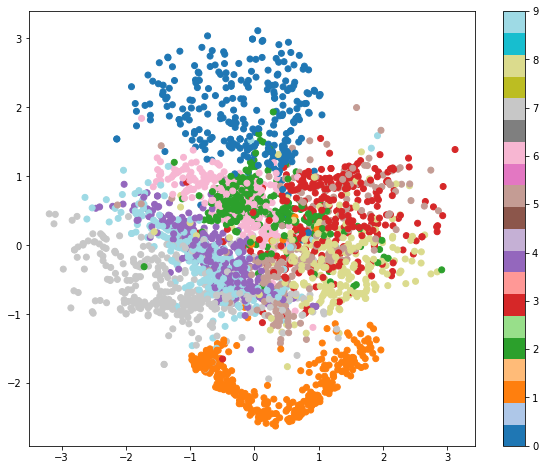

In [16]:
indices = np.random.randint(x_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_train[indices])

plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=Y_train[indices], cmap='tab20')
plt.colorbar()
plt.show()

7.2decoder

In [17]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))
VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_5 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               402192    
Total params: 468,624
Trainable params: 468,624
Non-trainable params: 0
_________________________________________________________________


In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [0]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

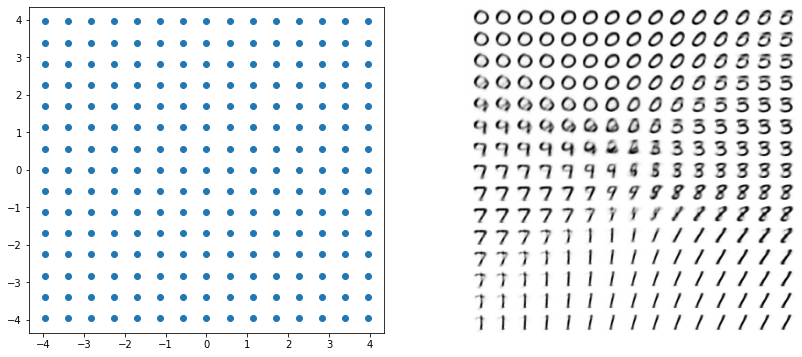

In [29]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

7.3比較

In [24]:
idx_1, idx_2 = np.random.randint(x_train.shape[0], size=2)
print(idx_1, idx_2)
def inBetween(t):
    data_0 = x_train[idx_1].reshape(28, 28)
    data_1 = x_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

28531 31413


In [25]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween>

In [0]:
'''data_0 = x_train[idx_1].reshape(28, 28)
data_1 = x_train[idx_2].reshape(28, 28)
data_t = (1-t)*data_0 + t*data_1
    
mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
mu_t = (1-t)*mu_0 + t*mu_1

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(2, 1, 2)
ax1.scatter(mu_0[0], mu_0[1])
ax1.scatter(mu_1[0], mu_1[1])
ax1.scatter(mu_t[0], mu_t[1])

ax2 = plt.subplot(2, 3, 1)
ax2.imshow(data_0, cmap='Greys')
ax2.set_title('t=0')

ax3 = plt.subplot(2, 3, 2)
ax3.imshow(data_t, cmap='Greys')
ax3.set_title(f't={t}')

ax4 = plt.subplot(2, 3, 3)
ax4.imshow(data_1, cmap='Greys')
ax4.set_title('t=1')'''